In [132]:
#|export
from fastbook import *

from fastai.vision.all import *
from fastai.vision.widgets import ImageClassifierCleaner

import gradio as gr

In [8]:
urls=search_images_ddg('bird images',max_images=1)
len(urls),urls[0]

(1,
 'https://img.xcitefun.net/users/2012/04/291966,xcitefun-392475-310475739025000-100001877283915-7.jpg')

In [32]:
dest=Path('bird.jpg')
if not dest.exists():
    download_url(urls[0],dest,show_progress=False)

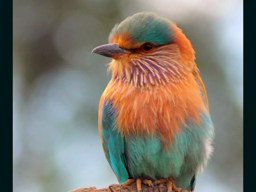

In [128]:
im=Image.open(dest)
im.to_thumb(256,256)

In [79]:
searches ='forest','bird'
p=Path('bird_or_not')
if not p.exists():
    for o in searches:
        dest=(p/o)
        print(dest)
        dest.mkdir(exist_ok=True)
        results=search_images_ddg(f'{o} photo')
        download_images(dest,urls=results[:200])
        resize_images(dest,max_size=400,dest=dest)

In [80]:
#unlink (delete) broken images  
#because if we train a model with broken images will not work 
failed=verify_images(get_image_files(path)) #get_image_files() return a list of all images in path 
failed.map(Path.unlink)

(#0) []

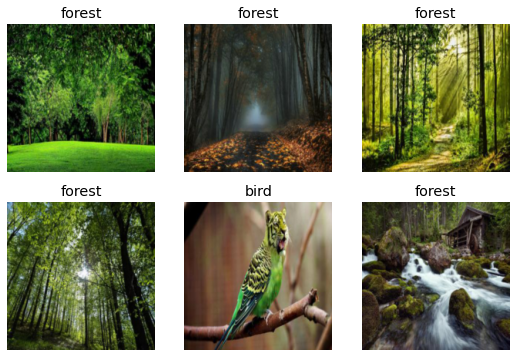

In [81]:
#DataBlock gives fast.ai all information that it needs to create computer vision model
dls=DataBlock(
    blocks=(ImageBlock,CategoryBlock),  #what kind of input we have? => ImageBlock
    # what kind of output => CategoryBlock (one of number of possibilities )
    get_items=get_image_files, #get images that we downloads (get_image_files is a function)
    splitter=RandomSplitter(valid_pct=0.2,seed=42), # 'validation set' (set aside 20% of data )
    get_y=parent_label, # how we od know the cooret label of a photo(to know if it's bird or forest photy)
    #(parent_label is a function return the parent folder of a path )
        item_tfms=[Resize(192,method='squish')] # most computer vision architectures needs all input to be same size
    #item_tfms : Item Transforms that is all of yhe bits of code that are run on every item (wil be 192 X 192)
    #there is 2 way : crop (crop out a piecein the middle) or squish (squish it )
    # and we can use Resize(192,ResizeMethod.Pad,pad_mode='zeros') -> it will fill with black color
).dataloaders(p) #data loaders are things that Pytorch iterates through to grab a bunch of your data at a time 
#الاستيلاء على جميع بياناتك في وقت واحد
#Data Loaders wiil feed training algorithm with a 'batch of your images at once ' دفعة واحدة من الصور 
dls.show_batch(max_n=6) #show 6 images (gives 2 things : input(image) and label (came by calling parent_label function  ))

exaple of squish and crop : https://docs.fast.ai/09_vision.augment_files/figure-html/cell-22-output-1.png

In [82]:
learn=cnn_learner(dls,resnet18,metrics=error_rate)
learn.fine_tune(3)
#leaner is a something that combines a mode(the actual neural network function we'll be training) 
# and the data (we use to train it with ) => so we pass two things : dls (is data) and model (resnet18)

# fine_tune methods : it takes pre-trained weights we downloaded and it adjusts them to teach the model the diffrernces 
#between your data set and what it was originally trained for 

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.691831,0.887710,0.280000,02:18


epoch,train_loss,valid_loss,error_rate,time
0,0.024067,0.085695,0.026667,03:33
1,0.015171,0.033294,0.013333,03:34
2,0.010227,0.014093,0.013333,03:22


In [160]:

#img=load_image(Path('bird_or_not/forest/070f1683-672d-47b4-a0e6-182492ab3b50.jpg'))

#is_bird,_,probs = learn.predict(img)

is_bird,_,probs = learn.predict('imagesExample/f.jpg')


print(f"this is a:{is_bird}.")
print(f"Probability its's a bird :{probs[0]:.4f}")
print(f"Probability its's a Forest :{probs[1]:.4f}")

this is a:forest.
Probability its's a bird :0.0000
Probability its's a Forest :1.0000


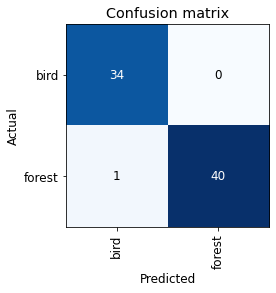

In [87]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

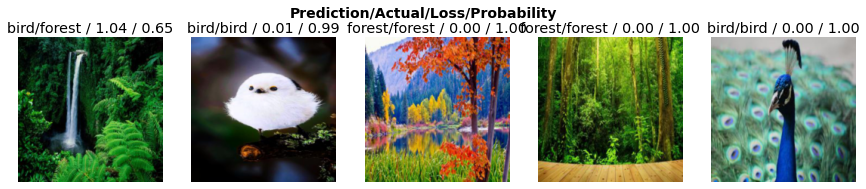

In [88]:
interp.plot_top_losses(5, nrows=1)

In [101]:
# now after train model we will use cleaner ImageClassifierCleaner to clean up the ones that are wrongly labeled in dataset
cleaner = ImageClassifierCleaner(learn) 
cleaner

In [ ]:
#after select from cleaner and delete we will apply changes

for idx in cleaner.delete(): 
    cleaner.fns[idx].unlink()
    
for idx,cat in cleaner.change():
    shutil.move(str(cleaner.fns[idx]), path/cat)

In [102]:
learn.export('model.pkl')

In [106]:
learn.predict(im)

('bird', TensorBase(0), TensorBase([1.0000e+00, 6.8869e-09]))

In [113]:
categories=('bird','forest')

def classify_image(img):
    pred,indx,probs=learn.predict(img)
    return dict(zip(categories,map(float,probs)))


In [129]:
classify_image(im)

{'bird': 1.0, 'forest': 6.886892389701416e-09}

In [152]:
image=gr.inputs.Image(shape=(192,192))
label=gr.outputs.Label()
examples=['imagesExample/a.jpg', 'imagesExample/b.jpg', 'imagesExample/dunno.jpg','imagesExample/c.jpg','imagesExample/d.jpg'
,'imagesExample/e.jpg','imagesExample/f.jpg','imagesExample/g.jpg']

interface=gr.Interface(fn=classify_image, inputs=image ,outputs=label,examples=examples)
interface.launch(inline=False)

C:\ProgramData\Anaconda3\lib\site-packages\gradio\inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\ProgramData\Anaconda3\lib\site-packages\gradio\outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\gradio\deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


In [151]:
intrface.close()

Closing server running on port: 7863


# Segmentation

Not just for image recognition 

In [48]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func( #function for labeling
    path, bs=8, fnames = get_image_files(path/"images"), #similar things that we pass to DataBlock 
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

#Segmentation color every pixel according what is it
#DataBlock is flexiable can hancdling almost any kind of data 
#but for kinds that occur a lot we can use special data loaders (ex. SegmentationDataLoaders) which allow us to use less code   


C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\Administrator/.cache\torch\hub\checkpoints\resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,time
0,2.724914,2.451092,01:51


epoch,train_loss,valid_loss,time
0,1.616665,1.531350,02:26
1,1.403830,1.264425,03:53
2,1.284731,1.262429,04:23
3,1.186923,1.087237,04:00
4,1.079317,1.031422,04:19
5,0.987714,0.953869,02:14
6,0.908204,0.957169,01:41
7,0.844796,0.943680,01:40


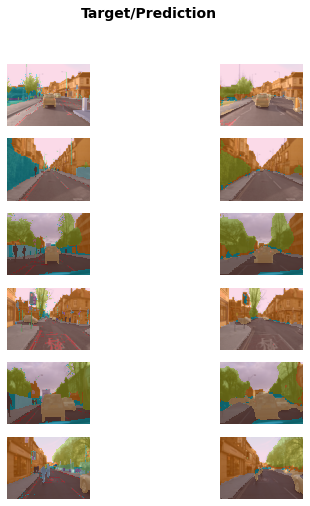

In [49]:
learn.show_results(max_n=6, figsize=(7,8))

# Tabular Analysis

In [52]:
from fastai.tabular.all import *
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation', # which column categorical 
                 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'], #which one continous 
    procs = [Categorify, FillMissing, Normalize])

learn = tabular_learner(dls, metrics=accuracy)

In [54]:
dls.show_batch()

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary
0,Private,HS-grad,Never-married,Other-service,Unmarried,White,False,38.0,273639.998344,9.0,<50k
1,Self-emp-not-inc,Masters,Divorced,Handlers-cleaners,Unmarried,White,False,41.0,254818.001062,14.0,<50k
2,Private,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,False,50.0,162632.000868,9.0,<50k
3,Private,5th-6th,Never-married,Handlers-cleaners,Not-in-family,White,False,76.0,243768.000746,3.0,<50k
4,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,False,23.0,179413.000376,9.0,<50k
5,Private,Assoc-voc,Divorced,Machine-op-inspct,Not-in-family,White,False,37.0,170407.999252,11.0,<50k
6,Private,Bachelors,Married-civ-spouse,Transport-moving,Husband,White,False,42.0,196029.000035,13.0,>=50k
7,Private,Some-college,Never-married,Machine-op-inspct,Own-child,White,False,26.0,152240.000814,10.0,<50k
8,Federal-gov,HS-grad,Widowed,Exec-managerial,Not-in-family,White,False,53.0,39643.000499,9.0,<50k
9,State-gov,Masters,Married-civ-spouse,Prof-specialty,Husband,White,False,41.0,36998.995203,14.0,>=50k


In [55]:
learn.fit_one_cycle(3) # fit not fine becuase Tabular is not generally to be pre trained model 
# becauase every table is differnt whereas picture have similar theme 

epoch,train_loss,valid_loss,accuracy,time
0,0.378393,0.371211,0.828931,00:20
1,0.363566,0.343451,0.841677,00:18
2,0.349166,0.342805,0.840909,00:16


# Collaborative Filltering 

In [60]:
from fastai.collab import *
path = untar_data(URLs.ML_SAMPLE)
print(path)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')


C:\Users\Administrator\.fastai\data\movie_lens_sample


In [61]:
dls.show_batch()

,userId,movieId,rating
0,518,1265,3.0
1,407,4993,5.0
2,564,1923,4.0
3,134,1206,4.0
4,587,608,4.0
5,615,3578,4.5
6,514,733,3.0
7,624,6539,3.5
8,88,1580,2.5
9,547,527,5.0


In [62]:
learn = collab_learner(dls, y_range=(0.5,5.5)) # range from 1-->5 but we will learn later why we use 0.5-->5.5
learn.fine_tune(10) #not fine but fit because it is not pre trained 
#but also fine tune work 


#valid_loss is 'mean sequared error'


epoch,train_loss,valid_loss,time
0,1.508429,1.420129,00:03


epoch,train_loss,valid_loss,time
0,1.367964,1.361230,00:04
1,1.270375,1.179813,00:04
2,1.043328,0.857622,00:05
3,0.805464,0.701831,00:03
4,0.700596,0.659320,00:03
5,0.646130,0.644762,00:04
6,0.625983,0.637567,00:03
7,0.611299,0.634506,00:00
8,0.604055,0.633914,00:00
9,0.595057,0.633776,00:01


In [63]:
learn.show_results()
#rating_pred : the rating that model predicated

,userId,movieId,rating,rating_pred
0,83.0,68.0,3.5,3.519715
1,91.0,42.0,4.0,3.185400
2,56.0,94.0,3.0,3.719958
3,65.0,92.0,4.5,4.166121
4,21.0,46.0,3.0,2.931408
5,98.0,23.0,4.5,3.306921
6,5.0,74.0,4.0,3.860805
7,65.0,70.0,2.5,3.726007
8,86.0,10.0,2.0,2.453387


# Cats & Dogs

In [ ]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)/'images' #PETS means animals  (Each image is labeled using its filename or instance, 
#the file great_pyrenees_173.jpg)
#( Pet dataset contains 7,390 pictures of dogs and cats, consisting of 37 breeds)

#this line downloads a standard dataset from the fast.ai datasets collection 
#(if not previously downloaded) to your server, extracts it (if not previously extracted), 
#and returns a Path object with the extracted location:

def is_cat(x): return x[0].isupper() #Note: The filenames start with an uppercase letter if the image is a cat
# and a lowercase letter other wise.

#In the third line, we define a function, is_cat, that labels cats 
#based on a filename rule provided by the dataset’s creators:

dls = ImageDataLoaders.from_name_func(# from_name_func (which means that filenames can be extracted using a function 
#applied to the filename) and passing x[0].isupper(), which evaluates to True if
#the first letter is uppercase (i.e., it’s a cat).
    
path, get_image_files(path), valid_pct=0.2, seed=42, # valid_pct=0.2 : This tells fastai to hold out 20% of the data and
#not use it for training the model at all. This 20% of the data is called the (""validation set""); 
#the remaining 80% is called the training set. (fastai defaults valid_pct to 0.2)
    
#seed=42:
#The parameter seed=42 sets the random seed to the same value every time we run this code,
# which means we get the same validation set every time we run it—this way, if we change our model and retrain it,
# we know that any differences are due to the changes to the model, not due to having a different ran‐ dom validation set    
    
label_func=is_cat, item_tfms=Resize(224)) # 224 : This is the standard size for historical reasons

#There are various classes for different kinds of deep learning datasets and problems— here we’re using ImageDataLoaders. 
#The first part of the class name will generally be the type of data you have, such as image or text.


#### The other important piece of information that we have to tell fastai is how to get the labels from the dataset. Computer vision datasets are normally structured in such a way that the label for an image is part of the filename or path—most commonly the parent folder name. fastai comes with a number of standardized labeling methods, and ways to write your own. Here we’re telling fastai to use the is_cat function we just defined.

#### Finally, we define the Transforms that we need. A Transform contains code that is applied automatically during training; fastai includes many predefined Transforms, and adding new ones is as simple as creating a Python function. There are two kinds: item_tfms are applied to each item (in this case, each item is resized to a 224-pixel square), while batch_tfms are applied to a batch of items at a time using the GPU, so they’re particularly fast (we’ll see many examples of these throughout this book).

#### fastai will always show you your model’s accuracy using only the validation set, never the training set

In [ ]:
#The fifth line of the code training our image recognizer tells fastai
#to create a convolutional neural network (CNN) and specifies what architecture to use
# (i.e., what kind of model to create) what data we want to train it on, and what metric to use: 
#cnn : convolutional neural network (CNN) شبكة عصبية تلافيفية
#إنها أحدث الأساليب المتبعة حاليًا في إنشاء نماذج الرؤية الحاسوبية. سنتعلم كل شيء عن كيفية عمل هيكلها مستوحى من كيفية عمل نظام الرؤية البشرية
learn = cnn_learner(dls, resnet34, metrics=error_rate)

#هناك بعض البنى القياسية التي تعمل معظم الوقت ، وفي هذه الحالة نستخدم واحدة تسمى
#ResNet 
#سنتحدث عنها كثيرًا في الكتاب ؛ إنه سريع ودقيق للعديد من مجموعات البيانات والمشكلات. يشير 34 في
#resnet34
#إلى عدد الطبقات في هذا المتغير من البنية (الخيارات الأخرى هي 18 و 50 و 101 و 152). تأخذ النماذج التي تستخدم البنى ذات الطبقات أكثر


#### A metric is a function that measures the quality of the model’s predictions using the validation set, and will be printed at the end of each epoch. In this case, we’re using error_rate, which is a function provided by fastai that does just what it says: tells you what percentage of images in the validation set are being classified incorrectly. Another common metric for classification is accuracy (which is just 1.0 - error_rate).

### A model that has weights that have already been trained on another dataset is called a ""pre‐trained"" model so =>we use  ( "pretrained" parameter in cnn_leaner( ) is TRUE in default   )  so we didn't write it.

## transfer learning. يُعرف استخدام نموذج تم اختباره مسبقًا لمهمة مختلفة عما تم تدريبه عليه في الأصل باسم 

In [ ]:
learn.fine_tune(1)
#1 : number of epochs 
# كلما قل عدد الدورات قل الوقت

In [76]:
import pandas as pd
s1 = pd.Series([5, 6, 7])
s2 = pd.Series([7, 8, 9])

df = pd.DataFrame([list(s1), list(s2)],  columns =  ["A", "B", "C"])

df2 = pd.DataFrame([[2,3,4]], columns=['A','B','C'])
df=pd.concat([df2, df])
df

,A,B,C
0,2,3,4
0,5,6,7
1,7,8,9


In [68]:
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')